<a href="https://colab.research.google.com/github/NethmiJayasinghe/Cerebellum/blob/main/MNIST_SurpriseDetection_SpikeSetPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/cerebellum

/content/gdrive/.shortcut-targets-by-id/1-1PwAYXnzX5UnHqeV31_ck5gfeNffQDu/cerebellum


In [3]:
!pip install brian2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00


In [4]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import json
import numpy

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train != 0) ]
y_train = y_train[(y_train != 0) ]

X_test = X_test[(y_test == 0) ]
y_test = y_test[(y_test == 0) ]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4
X_test = X_test / 4

X_train.shape, X_test.shape

((54077, 28, 28), (980, 28, 28))

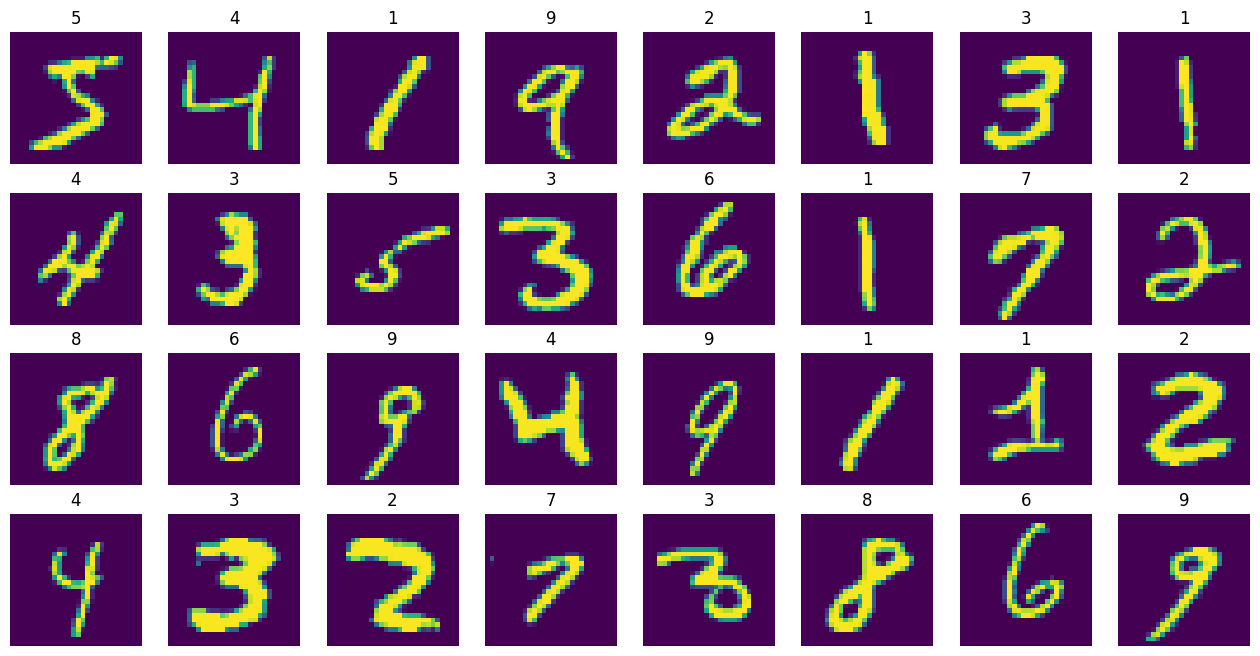

In [9]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [10]:
n_input = 28*28 # input layer
n_e = 1000 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

In [11]:
class Model():

    def __init__(self, debug=False):
        app = {}

        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV

        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp

        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M')

        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, epoch=1):
        self.net['S1'].lr = 1 # stdp on

        for ep in range(epoch):
            for idx in range(len(X)):

                if (idx % 100 == 0): print(str(epoch),"_",str(idx))
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)

    def evaluate(self, X):
        self.net['S1'].lr = 0  # stdp off
        store_idx = numpy.zeros(10).astype(int)

        for idx in range(len(X)):

            if (idx % 100 == 0): print(str(idx))

            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'])
            self.net.add(mon)

            # active mode (larger active mode)
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(5*second)

            file_name = "MNIST_epoch1_eineuron1000_train1to9/spike_dict_label_" + str(y_test[idx]) + "_instance_"+str(store_idx[y_test[idx]])+".txt"
            f = open(file_name,"w")
            f.write( str(mon.spike_trains()))
            f.close()
            store_idx[y_test[idx]] += 1

In [ ]:
def test1(train_items=1000, eval_items=1):

    seed(0)

    model = Model()
    model.train(X_train[:train_items], epoch=1)
    model.net.store('train', 'trainall_but_0_epoch_1_eineuron_1000')
    #model.net.restore('train', 'trainall_but_0_epoch_1_eineuron_1000')

    #model.evaluate(X_test[:eval_items])

test1()

1 _ 0
1 _ 100
1 _ 200
1 _ 300
1 _ 400
